# Generate test data

In [1]:
from EnzymePynetics.core.series import Series
from EnzymePynetics.core.species import Species
from EnzymePynetics.core.enzymekinetics import EnzymeKinetics
from EnzymePynetics.core.measurement import Measurement
from lmfit import Parameters, report_fit, minimize
from scipy.integrate import odeint
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt


%pwd


'/Users/max/code/EnzymePynetics'

## Irreversible MM

In [2]:
# Parameters of test reaction system
KM = 4
KCAT = 140
# k_inact = 0.1

init_sub = [0.5, 2, 4, 10, 15, 30]
ENZYME = 0.01

In [3]:
# Parameters for data generation
params = Parameters()
params.add("k_cat", value=KCAT, min=0.01 * KCAT, max=100 * KCAT)
params.add("K_m", value=KM, min=0.01 * KM, max=100 * KM)
# params.add("k_inact", value=0.12, min=0.0001, max=0.5)

In [4]:
# Kinetic model
def menten_irrev(w0: tuple, t, params):
    cS, cE, cP, cI = w0

    k_cat = params["k_cat"].value
    K_m = params["K_m"].value
    # k_inact = params['k_inact'].value

    dc_S = -k_cat * cE * cS / (K_m + cS)
    # dc_E = -cE * k_inact
    dc_E = 0
    dc_P = -dc_S
    dc_I = 0

    return (dc_S, dc_E, dc_P, dc_I)


# Integrator for MM rate equation
def g(t, w0, params):
    return odeint(menten_irrev, w0, t, args=(params,))

In [5]:
# Generate time-course data
time = np.arange(21)

substrate = np.empty((len(init_sub), len(time)))
for i, conc in enumerate(init_sub):
    substrate[i] = g(t=time, w0=(conc, ENZYME, 0, 0), params=params).T[0]

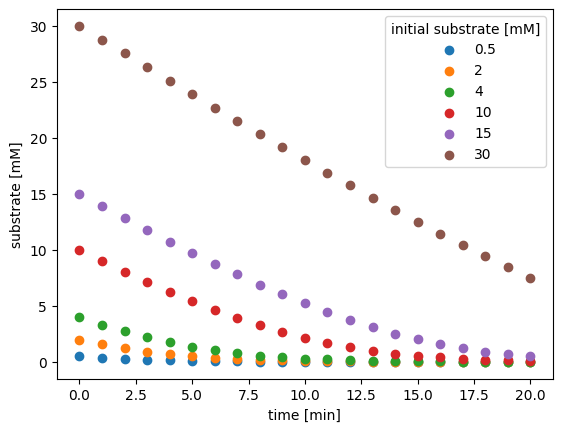

In [6]:
for conc, init_s in zip(substrate, init_sub):
    plt.scatter(time, conc, label=f"{init_s}")

plt.legend(title="initial substrate [mM]")
plt.ylabel("substrate [mM]")
plt.xlabel("time [min]")
plt.show()

In [7]:
def add_substrate(initial_conc, data): return Species(
    species_type="substrate",
    conc_unit="mmol / l",
    initial_conc=initial_conc,
    data=[Series(values=data)],
)


def add_enzyme(initial_conc): return Species(
    species_type="enzyme",
    conc_unit="mmol / l",
    initial_conc=initial_conc,
)

In [8]:
# Write data to json
measurements = []
print(time)

for init_substrate, sub in zip(init_sub, substrate):
    substrate = add_substrate(initial_conc=init_substrate, data=sub.tolist())
    enzyme = add_enzyme(ENZYME)

    measurements.append(
        Measurement(
            time_unit="min",
            time=time.tolist(),
            temperature=37,
            temperature_unit="C",
            pH=7,
            species=[substrate, enzyme],
        )
    )

enzyme_kinetics = EnzymeKinetics(
    title="test irreversible MM", measurements=measurements
)

with open("irrev_MM_enzyme.json", "w") as f:
    f.write(enzyme_kinetics.json())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [1]:
from itertools import groupby


def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

In [3]:
all_equal([1, 1, 1, 2, 1])

False

In [4]:
a, s, d = 1, 1, 1

In [5]:
a == s == d

True